In [1]:
import pandas as pd
import numpy as np
import imp

import data
import util

imp.reload(data)
imp.reload(util)

<module 'util' from 'C:\\Users\\graham\\classes\\ds_exp\\ds-project\\src\\util.py'>

In [2]:
daily = data.get_transit_daily()
# gets a smaller version for faster troubleshooting
daily = data.data_transforms(daily)


In [3]:
# print(sorted(daily))
# print(daily.describe())
# with pd.option_context("display.max_rows", None, "display.max_columns", None):
#     print(daily[["deviance", "label", "trip_id"]].head(1000))

In [4]:
# import functools


# # http://szudzik.com/ElegantPairing.pdf
# @functools.lru_cache()
# def pairing(a, b):
#     return a * a + a + b if a >= b else a + b * b


# daily["stop_id_pairing"] = np.vectorize(pairing)(
#     daily["stop_id"], daily["stop_id"].shift(1)
# )

In [5]:
# daily.describe().transpose()

In [6]:
# daily[
#     [
#         "arrival_time_y",
#         "departure_time_y",
#         "arrival_time_x",
#         "departure_time_x",
#         "ons",
#         "offs",
#     ]
# ][:50]

## how do we really want to structure this data?

* we want to make things somehow discrete by their trip_id
* so we want to somehow take the trip id and feed the model things about the trip
* we would feed it about the trip (up to different levels, and also expect it to answer about the whole trip each time
* yes so make a multi output thing that takes in a variable amount of information about the trip and answers about either - what it hasnt been supplied yet
* we want to have it somehow take in the previous x stops, and predict the next x stops?
* we dont want to punish it for guessing outside of the trip either
* we could also have it take in the last data to predict the stops
* start with only feeding it nothing besides day of the week and stuff, have it predict the times on the route
* slowly add in the realtime stats as the bus goes through its route, feeding it more each time
* we could either have it feed in more and more until it's filled, or just use a 0 padded window of bus stops. 
* let's look more into how rnn's and lstm's are normally constructed.


In [7]:
x = daily[data.USED_COLS]
x = pd.get_dummies(x)  # turns all categoricals into one hot encoded columns!

label = x.pop("label")

In [8]:
print("number of input features: ", len(sorted(x)))

number of input features:  459


In [9]:
import tensorflow as tf

tf.random.set_seed(1234)

# https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

# if batch size is one the net freaks out (maybe traning, maybe testing, either way, it's bad)
batch_size = 50
data_len = len(x)
train = 0.8
val = 0.1
test = 0.1

assert train + val + test == 1

train_size = int(train * data_len)
val_size = int(val * data_len)

dataset = tf.data.Dataset.from_tensor_slices((x.values, label.values))

# only shuffles the training set
train_dataset = dataset.take(train_size).shuffle(train_size).batch(batch_size)
val_dataset = dataset.skip(train_size).take(val_size).batch(batch_size)
test_dataset = dataset.skip(train_size).skip(val_size).batch(batch_size)

In [10]:
def get_compiled_model():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(500, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(50, activation="relu"),
            tf.keras.layers.Dense(50, activation="relu"),
            tf.keras.layers.Dense(50, activation="relu"),
            #             tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1),
        ]
    )

    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.MeanSquaredError(
            reduction="auto", name="mean_squared_error"
        ),
        metrics=["accuracy", "mean_absolute_error"],
    )

    return model

In [11]:
model = get_compiled_model()
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_mean_absolute_error", patience=10, restore_best_weights=True
)
model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[callback])

Epoch 1/100
8188/8188 [==============================] - 47s 6ms/step - loss: 9857.8125 - accuracy: 0.0042 - mean_absolute_error: 45.9945 - val_loss: 19961.9531 - val_accuracy: 0.0041 - val_mean_absolute_error: 93.0209
Epoch 2/100
8188/8188 [==============================] - 46s 6ms/step - loss: 8011.6577 - accuracy: 0.0042 - mean_absolute_error: 41.0965 - val_loss: 82910.4766 - val_accuracy: 0.0041 - val_mean_absolute_error: 72.7298
Epoch 3/100
8188/8188 [==============================] - 46s 6ms/step - loss: 7063.5542 - accuracy: 0.0043 - mean_absolute_error: 40.2982 - val_loss: 41246.8516 - val_accuracy: 0.0038 - val_mean_absolute_error: 52.2665
Epoch 4/100
8188/8188 [==============================] - 46s 5ms/step - loss: 6795.5181 - accuracy: 0.0042 - mean_absolute_error: 39.2753 - val_loss: 331230.0000 - val_accuracy: 0.0040 - val_mean_absolute_error: 89.3534
Epoch 5/100
8188/8188 [==============================] - 46s 5ms/step - loss: 6511.9053 - accuracy: 0.0041 - mean_absolute_

In [12]:
model.evaluate(test_dataset)

1024/1024 [==============================] - 4s 3ms/step - loss: 72694.4844 - accuracy: 0.0037 - mean_absolute_error: 44.8378


[72694.484375, 0.0037128229159861803, 44.837806701660156]

In [13]:
preds = []
labels = []
for data in test_dataset:
    preds.append(model.predict_on_batch(data[0]).flatten())
    labels.append(data[1])

preds = [p.tolist() for p in preds]
labels = [l.numpy().tolist() for l in labels]

preds = util.flatten(preds)
labels = util.flatten(labels)
assert len(preds) == len(labels)

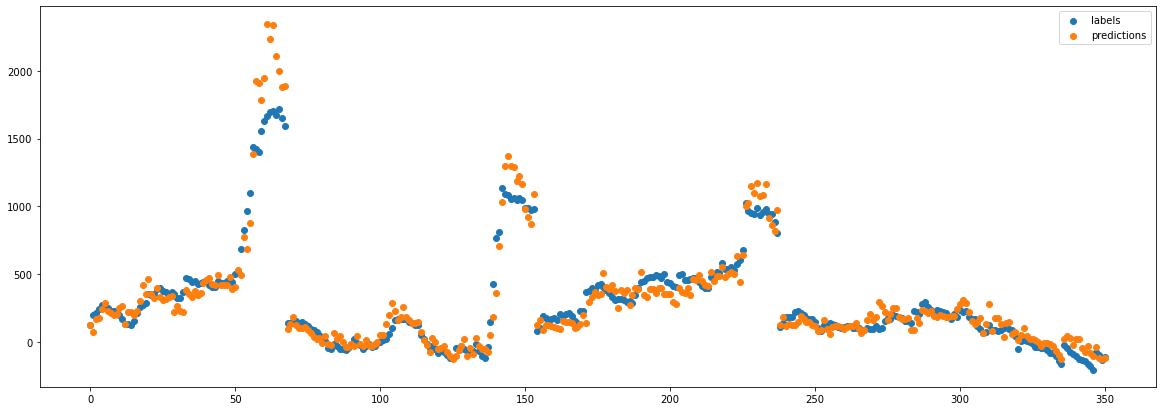

In [14]:
from matplotlib import pyplot as plt

# adjust these numbers to change the width and height of the plot!
plt.rcParams["figure.figsize"] = [20, 7]

util.plot(69, 420, preds, labels)

util.allDone()